In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import heart_disease.plotting as hdp
import heart_disease.preprocessing as pre_proc
import seaborn as sns
import pandas as pd
from copy import deepcopy as cp
%load_ext autoreload

from heart_disease.globals import code_path_str, data_path_str


from sklearn.pipeline import Pipeline
from sklearn.linear_model import perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import learning_curve, ShuffleSplit
%autoreload 2

In [2]:
# Get Metadata
meta_data_df = pd.read_csv(code_path_str+'meta_data.csv')

In [3]:
# Import Raw Data
data_file_name_str = 'processed.cleveland.data.txt'
data_df = pre_proc.load_raw_data(data_path_str+data_file_name_str,code_path_str+'meta_data.csv')
data_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,ispos_truth
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,False
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,True
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,True
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,False
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,False


In [4]:
full_pipe = Pipeline([
    ('cleaner', pre_proc.DataCleaner(code_path_str+'meta_data.csv').CleaningPipeline ),
    ('classifier',   SVC()),
    ])


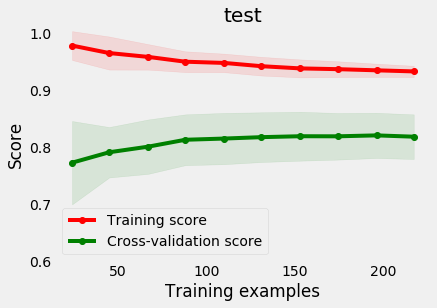

In [6]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
hdp.plot_learning_curve(full_pipe, 'test', data_df, data_df['ispos_truth'], ylim=(0.6, 1.01), cv=cv, n_jobs=4,
                    train_sizes=np.linspace(.1, 0.9, 10))
plt.show()